In [19]:
import scipy.io

# Load measurement data from a .mat file with a full path
data = scipy.io.loadmat('/dfs6/pub/gshalgum/CEE290AHW/measurement.mat')


# Extracting data from the loaded .mat file
obsTime = data['obsTime'].flatten()    # Make sure 'obsTime' is the correct key in the .mat file
obsPotEvap = data['obsPotEvap']        # Likewise for 'obsPotEvap'
obsPrecip = data['obsPrecip']          # And 'obsPrecip'
obsStorage = data['obsStorage'].flatten()  # And 'obsStorage'


In [ ]:
import numpy as np
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

# Load measurement data from a .mat file with a full path
data = scipy.io.loadmat('/dfs6/pub/gshalgum/CEE290AHW/measurement.mat')


# Extracting data from the loaded .mat file
obsTime = data['obsTime'].flatten()    # Make sure 'obsTime' is the correct key in the .mat file
obsPotEvap = data['obsPotEvap']        # Likewise for 'obsPotEvap'
obsPrecip = data['obsPrecip']          # And 'obsPrecip'
obsStorage = data['obsStorage'].flatten()  # And 'obsStorage'

def interceptionModel(t, S, P, E0, a, b, c, d):
    # Interpolators
    P_interp = interp1d(P[:, 0], P[:, 1], bounds_error=False, fill_value="extrapolate")
    E0_interp = interp1d(E0[:, 0], E0[:, 1], bounds_error=False, fill_value="extrapolate")
    
    # Interpolate values
    P_int = P_interp(t)
    E0_int = E0_interp(t)
    
    # Model calculations
    I = a * P_int
    D = b * np.maximum(S - c, 0)
    E = np.nan_to_num(d * E0_int * (S / c), nan=0.0) if c != 0 else 0
    
    # Change in storage
    dSdt = I - D - E
    
    return dSdt

def residuals(params, obsTime, obsPrecip, obsPotEvap, obsStorage):
    # Define a wrapper for solve_ivp that uses the whole time series
    def model(t, S):
        return interceptionModel(t, S, obsPrecip, obsPotEvap, *params)

    sol = solve_ivp(model, [obsTime[0], obsTime[-1]], [obsStorage[0]], t_eval=obsTime, vectorized=True)
    simulatedStorage = sol.y.flatten()
    return obsStorage - simulatedStorage

# Initial parameter guesses
initial_guess = [0.5, 1.0, 3.0, 0.5]  # Example: [a, b, c, d]

# Run optimization lm means  Levenberg-Marquardt algorithm
result = least_squares(residuals, initial_guess, args=(obsTime, obsPrecip, obsPotEvap, obsStorage), method='lm')

print("Optimized Parameters:", result.x)
print("Cost (Sum of Squares):", result.cost)


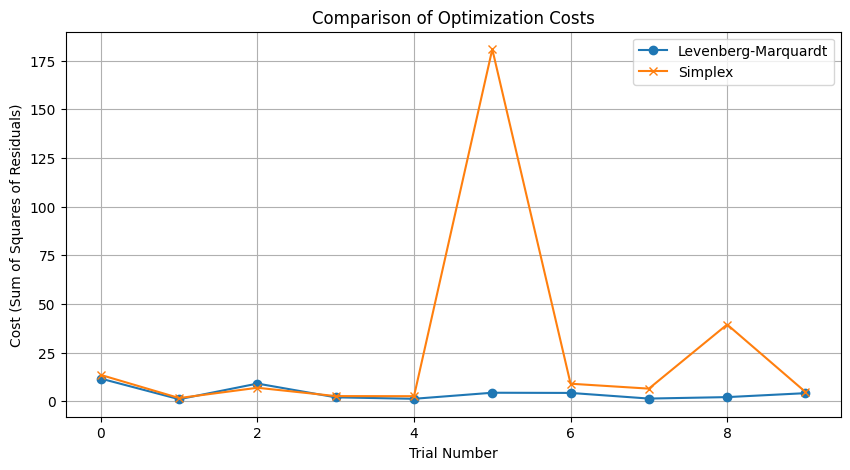

In [25]:
import numpy as np
import scipy.io
from scipy.optimize import least_squares, minimize
import matplotlib.pyplot as plt
def residuals(params, obsTime, obsPrecip, obsPotEvap, obsStorage):
    # Ensure `t_eval` matches `obsTime` length
    solution = solve_ivp(lambda t, y: interceptionModel(t, y, obsPrecip, obsPotEvap, *params),
                         [obsTime[0], obsTime[-1]], [obsStorage[0]], t_eval=obsTime)
    simulated_storage = solution.y.flatten()  # Ensure it flattens to the correct length
    return obsStorage - simulated_storage



def optimize(method, initial_guess):
    if method == 'lm':
        result = least_squares(residuals, initial_guess, args=(obsTime, obsPrecip, obsPotEvap, obsStorage), method='lm')
        return result.x, result.cost  # least_squares provides a 'cost' attribute directly
    elif method == 'simplex':
        result = minimize(lambda p: np.sum(residuals(p, obsTime, obsPrecip, obsPotEvap, obsStorage)**2), initial_guess, method='Nelder-Mead')
        return result.x, result.fun  # minimize uses 'fun' to store the final value of the function minimized

# Initial parameter guesses and results collection
num_trials = 10
results_lm = []
results_simplex = []

for _ in range(num_trials):
    initial_guess = np.random.rand(4)  # Random initial guess for [a, b, c, d]

    params_lm, cost_lm = optimize('lm', initial_guess)
    params_simplex, cost_simplex = optimize('simplex', initial_guess)

    results_lm.append((params_lm, cost_lm))
    results_simplex.append((params_simplex, cost_simplex))

# Plotting the results
costs_lm = [cost for _, cost in results_lm]
costs_simplex = [cost for _, cost in results_simplex]

plt.figure(figsize=(10, 5))
plt.plot(costs_lm, label='Levenberg-Marquardt', marker='o')
plt.plot(costs_simplex, label='Simplex', marker='x')
plt.title('Comparison of Optimization Costs')
plt.xlabel('Trial Number')
plt.ylabel('Cost (Sum of Squares of Residuals)')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
print(len(obsTime))
print(len(obsPrecip))
print(len(obsPotEvap))
print(len(obsStorage))


201
201
201
201
